In [2]:
%load_ext rpy2.ipython
%load_ext autoreload
%autoreload 2

%matplotlib inline  
from matplotlib import rcParams
rcParams['figure.figsize'] = (16, 100)

import warnings
from rpy2.rinterface import RRuntimeWarning
warnings.filterwarnings("ignore") # Ignore all warnings
# warnings.filterwarnings("ignore", category=RRuntimeWarning) # Show some warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, HTML

In [3]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}
pd.set_option('display.max_columns', None)

<IPython.core.display.Javascript object>

## Registration Data ##

### Load Registration Data ###

In [4]:
%%R

registration <- read.csv('RER_llistat_explotacions_catalanes.csv', fileEncoding = 'ISO-8859-1')
head(registration)


      MO      CODI.REGA ESTAT.EXPLOTACIÓ DATA.CANVI.ESTAT.EXPLOTACIÓ
1 0010AA ES250010030750           Activa                  21/01/1997
2 0010AA ES250010030750           Activa                  21/01/1997
3 0010AA ES250010030750           Activa                  21/01/1997
4 0010AA ES250010030750           Activa                  21/01/1997
5 0010AB ES250010031100           Activa                  21/04/1997
6 0010AC ES250010031700           Activa                  01/12/1997
           NOM.EXPLOTACIO  ADREÇA.EXPLOTACIÓ CODI.POSTAL.EXPLOTACIO
1 CASA JULIU - JORDI GASA        MASIA JULIU                  25651
2 CASA JULIU - JORDI GASA        MASIA JULIU                  25651
3 CASA JULIU - JORDI GASA        MASIA JULIU                  25651
4 CASA JULIU - JORDI GASA        MASIA JULIU                  25651
5            CASA GONELLA            BOIXOLS                  25651
6        SORT DE L'AGUSTÍ ABELLA DE LA CONCA                  25651
  SERVEI.TERRITORIAL..EXPLOTACIÓ PROVINCI

In [5]:
%%R

# Print Column Names
print(colnames(registration))

 [1] "MO"                             "CODI.REGA"                     
 [3] "ESTAT.EXPLOTACIÓ"               "DATA.CANVI.ESTAT.EXPLOTACIÓ"   
 [5] "NOM.EXPLOTACIO"                 "ADREÇA.EXPLOTACIÓ"             
 [7] "CODI.POSTAL.EXPLOTACIO"         "SERVEI.TERRITORIAL..EXPLOTACIÓ"
 [9] "PROVINCIA.EXPLOTACIÓ"           "COMARCA.EXPLOTACIÓ"            
[11] "MUNICIPI.EXPLOTACIÓ"            "COORDENADA.X.EXPLOTACIÓ"       
[13] "COORDENADA.Y.EXPLOTACIÓ"        "LATITUD.EXPLOTACIÓ"            
[15] "LONGITUD.EXPLOTACIÓ"            "TIPUS.EXPLOTACIÓ"              
[17] "ESPÈCIE"                        "SUBESPÈCIE"                    
[19] "TIPUS.SUBEXPLOTACIÓ"            "ESTAT.SUBEXPLOTACIÓ"           
[21] "DATA.CANVI.ESTAT.SUBEXPLOTACIÓ" "INTEGRADORA"                   
[23] "NOM.ADS"                        "CLASSIFICACIÓ.ZOOTÈCNICA"      
[25] "DATA.CLASSIFICACIÓ.ZOOTÈCNICA"  "FORMA.DE.CRIA"                 
[27] "AUTOCONSUM"                     "SISTEMA.PRODUCTIU"             
[29] "

### EDA - PRODUCTION SYSTEM ###

In [24]:
%%R
# Print the unique values of the column 'SISTEMA.PRODUCTIU'
unique(registration$SISTEMA.PRODUCTIU)

[1] "Extensiu"     "Intensiu"     "Semiextensiu" ""            


In [25]:
%%R
# Calculate the sum of "TOTAL.URM" for each unique value of "SISTEMA.PRODUCTIU"
aggregate(registration$TOTAL.URM, by=list(registration$SISTEMA.PRODUCTIU), FUN=sum)

       Group.1         x
1                    0.0
2     Extensiu  157736.0
3     Intensiu 1631762.3
4 Semiextensiu  171058.1


URM possibly stands for Unitat Ramadera Major (Major Livestock Unit), representing a standard measure of livestock equivalent units. The intensive type of industry here has the highes number of livestock units.

In [26]:
%%R
# Calculate the sum of "TOTAL.NITROGEN" for each unique value of "SISTEMA.PRODUCTIU"
aggregate(registration$TOTAL.NITROGEN, by=list(registration$SISTEMA.PRODUCTIU), FUN=sum)

       Group.1        x
1                     0
2     Extensiu  8564994
3     Intensiu 92066212
4 Semiextensiu  8706544


In [35]:
%%R
# Remove rows with NA values or where TOTAL.URM is zero
clean_data <- registration[!is.na(registration$TOTAL.NITROGEN) & 
                           !is.na(registration$TOTAL.URM) & 
                           registration$TOTAL.URM != 0, ]

# Calculate the per URM nitrogen for each unique value of "SISTEMA.PRODUCTIU"
result <- aggregate(clean_data$TOTAL.NITROGEN/clean_data$TOTAL.URM, 
                    by=list(clean_data$SISTEMA.PRODUCTIU), 
                    FUN=function(x) mean(x, na.rm = TRUE))

print(result)

       Group.1        x
1     Extensiu 59.87176
2     Intensiu 59.86357
3 Semiextensiu 60.83892


#### Summary ####
* It demonstrates that the intensive type has the highest nitrogen emission.
* However, the per unit emission of the three types are similar.

### EDA - SPECIES ###

In [36]:
%%R
# Print the unique values of the column 'ESPÈCIE'
unique(registration$ESPÈCIE)

 [1] "Boví"                                                      
 [2] "Porcí"                                                     
 [3] "Èquid"                                                     
 [4] "Abella"                                                    
 [5] "Cabrum"                                                    
 [6] "Oví"                                                       
 [7] "Ratites"                                                   
 [8] "Gallines i pollastres"                                     
 [9] "Conill"                                                    
[10] "Galls dindi"                                               
[11] "Perdius"                                                   
[12] "Guatlles"                                                  
[13] "Faisans"                                                   
[14] "Coloms"                                                    
[15] "Oques"                                                     
[16] "Ànec

In [44]:
%%R
# Calculate the sum of "TOTAL.URM" for each unique value of "ESPÈCIE" and sort the result
result <- aggregate(registration$TOTAL.URM, by=list(registration$ESPÈCIE), FUN=sum)
result <- result[order(result$x, decreasing = TRUE), ]
print(result)

                                                      Group.1          x
60                                                      Porcí 1029467.23
9                                                        Boví  546121.20
34                                      Gallines i pollastres  147833.76
55                                                        Oví  109674.19
25                                                      Èquid   86347.20
35                                                Galls dindi   13962.83
10                                                     Cabrum   10736.75
19                                                     Conill    8234.07
37                                                   Guatlles    5226.64
57                                                    Perdius    2149.43
6                                                       Ànecs     379.22
33                                                    Faisans     331.19
61                                                 

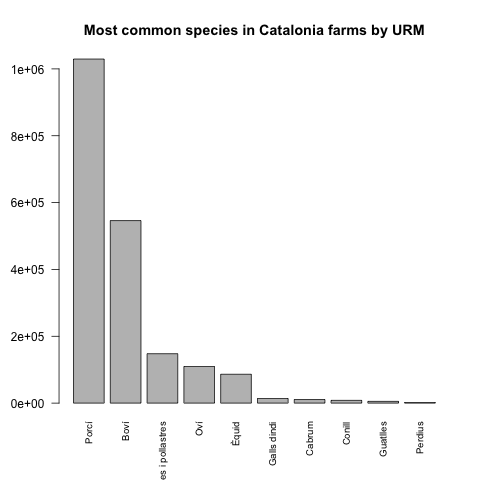

In [42]:
%%R
# Draw a bar chart of the Top 10 ESPÈCIE by TOTAL.URM
top10_especie <- aggregate(registration$TOTAL.URM, by=list(registration$ESPÈCIE), FUN=sum)
top10_especie <- top10_especie[order(-top10_especie$x),]
top10_especie <- head(top10_especie, 10)
# Name the chart "Most common species in Catalonia farms by URM"
barplot(top10_especie$x, names.arg=top10_especie$Group.1, las=2, cex.names=0.8, main="Most common species in Catalonia farms by URM")

In [47]:
%%R
# Calculate the sum of "TOTAL.NITROGEN" for each unique value of "ESPÈCIE"
result <- aggregate(registration$TOTAL.NITROGEN, by=list(registration$ESPÈCIE), FUN=sum)
result <- result[order(result$x, decreasing = TRUE), ]
print(result)

                                                      Group.1           x
60                                                      Porcí 62670736.07
9                                                        Boví 21429584.52
34                                      Gallines i pollastres  9919155.54
55                                                        Oví  5565813.00
25                                                      Èquid  5542384.00
35                                                Galls dindi  2051711.04
10                                                     Cabrum   858806.40
19                                                     Conill   678918.05
37                                                   Guatlles   393114.58
57                                                    Perdius   168638.08
6                                                       Ànecs    30630.50
33                                                    Faisans    26864.51
63                                    

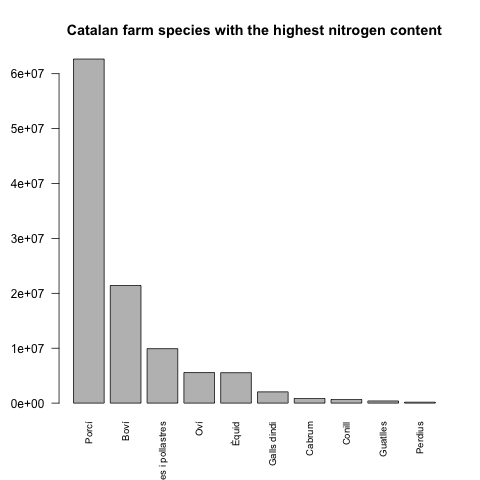

In [49]:
%%R
# Draw a bar chart of the Top 10 ESPÈCIE by TOTAL.NITROGEN
top10_especie <- aggregate(registration$TOTAL.NITROGEN, by=list(registration$ESPÈCIE), FUN=sum)
top10_especie <- top10_especie[order(-top10_especie$x),]
top10_especie <- head(top10_especie, 10)
# Name the chart "Catalan farm species with the highest nitrogen content"
barplot(top10_especie$x, names.arg=top10_especie$Group.1, las=2, cex.names=0.8, main= "Catalan farm species with the highest nitrogen content")

In [52]:
%%R
# Remove rows with NA values or where TOTAL.URM is zero
clean_data <- registration[!is.na(registration$TOTAL.NITROGEN) & 
                           !is.na(registration$TOTAL.URM) & 
                           registration$TOTAL.URM != 0, ]

# Calculate the per URM nitrogen for each unique value of "ESPÈCIE"
result <- aggregate(clean_data$TOTAL.NITROGEN/clean_data$TOTAL.URM, 
                    by=list(clean_data$ESPÈCIE), 
                    FUN=function(x) mean(x, na.rm = TRUE))

# Sort the result
result <- result[order(result$x, decreasing = TRUE), ]
print(result)

                 Group.1          x
8            Galls dindi 138.584843
4                 Conill  83.930504
6                Faisans  80.263388
3                 Cabrum  79.945665
10                 Oques  79.663095
7  Gallines i pollastres  78.775203
12               Perdius  78.521290
1                  Ànecs  78.362341
9               Guatlles  76.661485
5                  Èquid  64.029442
13                 Porcí  61.066497
15               Senglar  60.225000
11                   Oví  54.293862
2                   Boví  37.295109
14               Ratites   4.089044


#### Summary ####
* Traditional livestocks, such as pig, chicken, cattle and sheep, can be found easily in Catalonia.
* These species, especially pig, contributed greatly to the nitrogen emission.
* However, smaller species such as turkeys and rabbits, have higher per URM nitrogen emission.

### EDA - Date ###

In [59]:
%%R
# From 'DATA.CANVI.ESTAT.EXPLOTACIÓ' column, extract the year, and put it in a new column 'YEAR'
registration$YEAR <- as.numeric(format(as.Date(registration$DATA.CANVI.ESTAT.EXPLOTACIÓ, format="%d/%m/%Y"), "%Y"))

In [71]:
%%R
# How many farms were registered each year?
result <- aggregate(registration$YEAR, by=list(registration$YEAR), FUN=length)
print(result)

   Group.1    x
1     1991  136
2     1992 2615
3     1993 5167
4     1994 1808
5     1995 1493
6     1996  799
7     1997  574
8     1998  370
9     1999  337
10    2000  500
11    2001  281
12    2002  359
13    2003  401
14    2004  363
15    2005  264
16    2006  314
17    2007  318
18    2008  318
19    2009  448
20    2010  788
21    2011  554
22    2012  479
23    2013  589
24    2014  670
25    2015  618
26    2016  619
27    2017  669
28    2018  634
29    2019  673
30    2020  800
31    2021  863
32    2022  744
33    2023  650
34    2024  123


In [68]:
%%R
# Calculate the sum of "TOTAL.URM" for each unique value of "YEAR", and sort the result by the sum
result <- aggregate(registration$TOTAL.URM, by=list(registration$YEAR), FUN=sum)
result <- result[order(result$x, decreasing = TRUE), ]
print(result)

   Group.1         x
3     1993 514066.23
2     1992 275908.35
4     1994 228664.94
5     1995 192943.23
6     1996  97259.43
7     1997  66141.85
8     1998  42302.77
10    2000  35749.20
9     1999  32379.12
24    2014  29352.95
26    2016  26491.47
11    2001  25462.93
17    2007  24565.23
12    2002  24509.66
13    2003  23731.28
25    2015  23420.32
27    2017  22227.65
23    2013  22149.39
20    2010  21935.44
14    2004  20785.20
22    2012  20527.63
16    2006  20459.47
28    2018  20309.05
29    2019  19795.16
30    2020  17966.00
1     1991  15418.49
21    2011  15226.41
15    2005  15058.94
19    2009  15015.52
18    2008  14380.32
31    2021  13735.99
32    2022  11363.75
33    2023   9213.59
34    2024   2039.48


In [73]:
%%R

# Calculate the TOTAL.URM per farm for each unique value of "YEAR", and sort the result by the mean
result <- aggregate(registration$TOTAL.URM, by=list(registration$YEAR), FUN=mean)
result <- result[order(result$x, decreasing = TRUE), ]
print(result)

   Group.1         x
5     1995 129.23190
4     1994 126.47397
6     1996 121.72645
7     1997 115.22970
8     1998 114.33181
1     1991 113.37125
2     1992 105.50989
3     1993  99.49027
9     1999  96.08047
11    2001  90.61541
17    2007  77.24915
10    2000  71.49840
12    2002  68.27203
16    2006  65.15755
13    2003  59.18025
14    2004  57.25950
15    2005  57.04144
18    2008  45.22113
24    2014  43.81037
22    2012  42.85518
26    2016  42.79721
25    2015  37.89696
23    2013  37.60508
19    2009  33.51679
27    2017  33.22519
28    2018  32.03320
29    2019  29.41331
20    2010  27.83685
21    2011  27.48449
30    2020  22.45750
34    2024  16.58114
31    2021  15.91656
32    2022  15.27386
33    2023  14.17475


In [69]:
%%R
# Calculate the sum of "TOTAL.NITROGEN" for each unique value of "YEAR", and sort the result by the sum
result <- aggregate(registration$TOTAL.NITROGEN, by=list(registration$YEAR), FUN=sum)
result <- result[order(result$x, decreasing = TRUE), ]
print(result)

   Group.1          x
3     1993 28350700.4
2     1992 15325088.6
4     1994 12662520.8
5     1995 11411768.2
6     1996  5842516.1
7     1997  3868568.9
8     1998  2325502.5
10    2000  1853397.8
9     1999  1758267.1
24    2014  1588489.8
26    2016  1493721.9
11    2001  1442629.9
17    2007  1390302.7
25    2015  1297427.6
22    2012  1270977.9
16    2006  1263792.5
12    2002  1193171.8
20    2010  1184716.9
27    2017  1172276.3
13    2003  1140198.7
23    2013  1134788.0
28    2018  1049488.8
14    2004  1047454.5
29    2019  1033495.6
30    2020   927401.6
19    2009   914694.9
1     1991   855266.9
31    2021   848214.1
21    2011   843960.6
18    2008   805883.5
15    2005   766575.8
32    2022   630533.7
33    2023   538767.5
34    2024   105188.8


In [74]:
%%R

# Calculate the TOTAL.NITROGEN per farm for each unique value of "YEAR", and sort the result by the mean
result <- aggregate(registration$TOTAL.NITROGEN, by=list(registration$YEAR), FUN=mean)
result <- result[order(result$x, decreasing = TRUE), ]
print(result)

   Group.1         x
5     1995 7643.5152
6     1996 7312.2855
4     1994 7003.6066
7     1997 6739.6670
1     1991 6288.7276
8     1998 6285.1418
2     1992 5860.4545
3     1993 5486.8783
9     1999 5217.4099
11    2001 5133.9141
17    2007 4372.0212
16    2006 4024.8168
10    2000 3706.7955
12    2002 3323.5983
15    2005 2903.6963
14    2004 2885.5497
13    2003 2843.3883
22    2012 2653.3986
18    2008 2534.2249
26    2016 2413.1210
24    2014 2370.8803
25    2015 2099.3973
19    2009 2041.7298
23    2013 1926.6350
27    2017 1752.2815
28    2018 1655.3451
29    2019 1535.6547
21    2011 1523.3945
20    2010 1503.4478
30    2020 1159.2520
31    2021  982.8668
34    2024  855.1937
32    2022  847.4915
33    2023  828.8732


#### Summary ####
From 1992-95, a large number of farms were registered in Catalonia. They contribute to a large portion of nitrogen emission, and are possibly large farms according to per farm nitrogen emission.

### EDA - GEO ###

In [85]:
%%R

# Calculate the total URM of each CODI POSTAL EXPLOTACIO and sort the result
result <- aggregate(registration$TOTAL.URM, by=list(registration$CODI.POSTAL.EXPLOTACIO), FUN=sum)
result <- result[order(result$x, decreasing = TRUE), ]
print(result)

    Group.1        x
552   25180 57793.86
168    8519 32610.05
504   25100 28996.83
573   25212 22359.99
515   25126 22064.78
725   25730 22011.94
733   25749 20720.22
153    8503 20615.99
606   25286 20081.78
633   25430 18136.10
526   25140 17656.22
688   25616 16934.94
611   25310 16462.66
160    8511 15623.96
527   25141 14707.47
698   25650 14257.73
705   25680 14238.03
85     8281 14205.41
514   25125 13547.76
728   25737 12684.40
199    8619 12468.02
607   25287 12079.08
553   25181 11977.60
335   17176 11864.68
683   25600 11847.07
622   25337 11677.39
614   25318 11459.18
196    8612 10795.82
528   25142 10537.35
167    8518 10323.46
572   25211 10319.46
817   43500 10041.77
397   17469  9726.78
825   43520  9337.69
542   25170  9131.24
704   25670  9073.48
522   25136  9058.55
608   25289  9055.98
625   25344  8890.01
177    8560  8803.11
591   25260  8739.51
832   43550  8655.75
597   25266  8513.43
558   25186  8486.76
521   25135  8466.35
612   25316  8457.62
73     8261  

In [86]:
%%R

# Calculate the total nitrogen of each CODI POSTAL EXPLOTACIO and sort the result
result <- aggregate(registration$TOTAL.NITROGEN, by=list(registration$CODI.POSTAL.EXPLOTACIO), FUN=sum)
result <- result[order(result$x, decreasing = TRUE), ]
print(result)

    Group.1          x
552   25180 2507827.59
168    8519 1873095.48
504   25100 1388091.97
725   25730 1278368.37
515   25126 1206939.09
733   25749 1189582.41
606   25286 1147471.23
633   25430 1145905.26
153    8503 1136072.46
573   25212 1131852.79
526   25140 1110193.88
85     8281  904851.30
611   25310  903394.83
688   25616  886144.54
527   25141  874671.20
160    8511  871640.33
698   25650  796754.71
817   43500  792980.57
728   25737  780894.48
705   25680  730044.46
614   25318  700513.80
622   25337  691793.16
199    8619  680311.86
607   25287  672260.15
825   43520  666985.07
553   25181  658177.37
514   25125  649348.88
335   17176  629009.39
683   25600  610400.68
528   25142  602806.75
196    8612  598623.93
572   25211  584160.59
167    8518  545520.27
832   43550  533669.21
608   25289  529391.34
597   25266  527990.30
589   25245  517142.57
625   25344  513411.40
704   25670  513236.22
397   17469  490470.88
177    8560  484880.68
612   25316  475211.41
166    8517

In [88]:
%%R

# Calculate the total URM of each PROVINCIA.EXPLOTACIÓ and sort the result
result <- aggregate(registration$TOTAL.URM, by=list(registration$PROVINCIA.EXPLOTACIÓ), FUN=sum)
result <- result[order(result$x, decreasing = TRUE), ]
print(result)

    Group.1         x
3    Lleida 1028081.5
1 Barcelona  449214.2
2    Girona  317586.8
4 Tarragona  165673.9


In [89]:
%%R

# Calculate the total nitrogen of each PROVINCIA.EXPLOTACIÓ and sort the result
result <- aggregate(registration$TOTAL.NITROGEN, by=list(registration$PROVINCIA.EXPLOTACIÓ), FUN=sum)
result <- result[order(result$x, decreasing = TRUE), ]
print(result)

    Group.1        x
3    Lleida 55606661
1 Barcelona 25109176
2    Girona 17673277
4 Tarragona 10948637


In [90]:
%%R

# Calculate the total URM of each MUNICIPI.EXPLOTACIÓ and sort the result
result <- aggregate(registration$TOTAL.URM, by=list(registration$MUNICIPI.EXPLOTACIÓ), FUN=sum)
result <- result[order(result$x, decreasing = TRUE), ]
print(result)

                                        Group.1        x
23                                     Alcarràs 57793.86
378                                      Lleida 29774.63
38                                   Almacelles 27132.41
71                              Artesa de Segre 22688.64
40                                      Almenar 22064.78
346                                        Gurb 20641.49
363                                      Juneda 18136.10
55                                       Arbeca 17402.12
4                                      Agramunt 16702.66
451                                     Montgai 16608.47
484                                      Oliola 16255.85
319               Gimenells i el Pla de la Font 15305.45
352                         Isona i Conca Dellà 14883.94
819                                 Torregrossa 14707.47
851                      Vallfogona de Balaguer 14524.83
364                                  l'Esquirol 13694.48
35                             

In [91]:
%%R

# Calculate the total nitrogen of each MUNICIPI.EXPLOTACIÓ and sort the result
result <- aggregate(registration$TOTAL.NITROGEN, by=list(registration$MUNICIPI.EXPLOTACIÓ), FUN=sum)
result <- result[order(result$x, decreasing = TRUE), ]
print(result)

                                        Group.1          x
23                                     Alcarràs 2507827.59
378                                      Lleida 1324339.20
71                              Artesa de Segre 1310856.57
38                                   Almacelles 1290472.32
40                                      Almenar 1206939.09
363                                      Juneda 1145905.26
346                                        Gurb 1138189.86
55                                       Arbeca 1094929.88
484                                      Oliola  936708.89
4                                      Agramunt  917894.83
451                                     Montgai  877264.94
819                                 Torregrossa  874671.20
352                         Isona i Conca Dellà  841911.02
830                                     Tortosa  795026.97
364                                  l'Esquirol  764059.53
319               Gimenells i el Pla de la Font  750231.

In [101]:
%%R

# How many farms are there in each MUNICIPI.EXPLOTACIÓ?
result <- aggregate(registration$MUNICIPI.EXPLOTACIÓ, by=list(registration$MUNICIPI.EXPLOTACIÓ), FUN=length)
result <- result[order(result$x, decreasing = TRUE), ]
print(result)

                                        Group.1   x
23                                     Alcarràs 390
378                                      Lleida 275
256                                    Deltebre 190
40                                      Almenar 178
830                                     Tortosa 175
346                                        Gurb 174
52                                      Amposta 161
843                               Vall d'en Bas 159
646                    Sant Carles de la Ràpita 150
402                                     Manresa 147
38                                   Almacelles 142
71                              Artesa de Segre 137
364                                  l'Esquirol 128
431                                        Moià 127
851                      Vallfogona de Balaguer 125
363                                      Juneda 120
108                         Bellver de Cerdanya 117
187                                     Cardona 116
619         

In [118]:
%%R

# Calculate the total nitrogen for each MUNICIPI.EXPLOTACIÓ
result <- aggregate(registration$TOTAL.NITROGEN, by=list(registration$MUNICIPI.EXPLOTACIÓ), FUN=sum)

# Calculate the number of farms in each MUNICIPI.EXPLOTACIÓ
farms <- aggregate(registration$MUNICIPI.EXPLOTACIÓ, by=list(registration$MUNICIPI.EXPLOTACIÓ), FUN=length)

# Calculate the mean nitrogen per farm for each MUNICIPI.EXPLOTACIÓ
result <- merge(result, farms, by="Group.1")
result$mean_nitrogen <- result$x.x / result$x.y
result <- result[order(result$mean_nitrogen, decreasing = TRUE), ]
print(result)

                                        Group.1        x.x x.y mean_nitrogen
202                                 Castelldans  324156.60  19   17060.87368
286                                    Floresta   95187.56   6   15864.59333
492                           Omells de na Gaia   73254.25   5   14650.85000
777                                       Soses  658177.37  45   14626.16378
801                                     Tiurana   29000.00   2   14500.00000
484                                      Oliola  936708.89  68   13775.13074
297                                    Foradada  443462.05  33   13438.24394
560                                       Ponts  385343.40  29   13287.70345
210                        Castelló de Farfanya  471202.84  36   13088.96778
93                                     Bassella  353573.89  28   12627.63893
329                                  Granadella  320791.85  26   12338.14808
10                                       Aitona  332799.41  27   12325.90407

### Regression - URM vs Nitrogen ###

In [6]:
%%R

# Run a linear regression of TOTAL.NITROGEN on TOTAL.URM
result <- lm(registration$TOTAL.NITROGEN ~ registration$TOTAL.URM)
print(summary(result))


Call:
lm(formula = registration$TOTAL.NITROGEN ~ registration$TOTAL.URM)

Residuals:
   Min     1Q Median     3Q    Max 
-55482    162    190    340  64398 

Coefficients:
                        Estimate Std. Error t value Pr(>|t|)    
(Intercept)            -162.1638    18.1933  -8.913   <2e-16 ***
registration$TOTAL.URM   57.9472     0.1191 486.483   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 2578 on 26336 degrees of freedom
Multiple R-squared:  0.8999,	Adjusted R-squared:  0.8999 
F-statistic: 2.367e+05 on 1 and 26336 DF,  p-value: < 2.2e-16



## Inspection Data ##

### Load Inspection Data ###

In [120]:
%%R

inspection <- read.csv('FOCUS_INSPECCIONS_AMBIENTALS - FOCUS_INSPECCIONS_AMBIENTALS.csv', fileEncoding = 'ISO-8859-1')
head(inspection)

  IDQA  COORD_X COORD_Y                           ESTABLIMENT
1   33 412706.0 4604855       DIPOSIT CONTROLAT DE VACARISSES
2   34 504287.5 4644300                       GRANJA LA VINYA
3   35 427137.0 4595030         MOREDA RIVIERE TREFILERIAS SA
4   36 358200.0 4615370 DIPÃ\u0092SIT CONTROLAT DE LA SEGARRA
5   37 326238.0 4626149                         GRANJA PEDROS
6   38 345250.0 4565500       BALL BEVERAGE PACKAGING IBERICA
                                                     TITULAR
1 HERA HOLDING HABITAT ECOLOGIA Y RESTAURACION AMBIENTAL, SL
2                                        JOSEP DEVALL DALMAU
3                              MOREDA RIVIERE TREFILERIAS SA
4                             CONSELL COMARCAL DE LA SEGARRA
5                                   JOSEP MARIA PEDROS CARBI
6                        BALL BEVERAGE PACKAGING IBERICA, SL
                          GRUP_ACTIVITAT EPIGRAF_DEI  EPIGRAF_PCAA
1 Gestor de residus - DipÃ²sit controlat         5.5    I.1 - 10.6
2    

In [121]:
%%R

# Print Column Names
print(colnames(inspection))

 [1] "IDQA"                  "COORD_X"               "COORD_Y"              
 [4] "ESTABLIMENT"           "TITULAR"               "GRUP_ACTIVITAT"       
 [7] "EPIGRAF_DEI"           "EPIGRAF_PCAA"          "INFORME_PROGRAMA_2018"
[10] "INFORME_PROGRAMA_2017" "INFORME_PROGRAMA_2016" "INFORME_PROGRAMA_2015"
[13] "GEOMETRIA"            


In [122]:
%%R

# Get all unique values of GRUP_ACTIVITAT
unique(inspection$GRUP_ACTIVITAT)

[1] "Gestor de residus - DipÃ²sit controlat"
[2] "ExplotaciÃ³ ramadera"                  
[3] "Industrial"                            
[4] "Gestor de residus"                     


#### Filter out livestock industry ####

In [123]:
%%R

# Keep only the rows where the value of 'GRUP_ACTIVITAT' is 'ExplotaciÃ³ ramadera'
inspection <- inspection[inspection$GRUP_ACTIVITAT == 'ExplotaciÃ³ ramadera', ]

#### Count number of inspections every year ####

In [141]:
%%R

# Count number of rows not equal to - in each year
count_2018 <- sum(inspection$INFORME_PROGRAMA_2018 != '-')
count_2017 <- sum(inspection$INFORME_PROGRAMA_2017 != '-')
count_2016 <- sum(inspection$INFORME_PROGRAMA_2016 != '-')
count_2015 <- sum(inspection$INFORME_PROGRAMA_2015 != '-')
print(c(count_2018, count_2017, count_2016, count_2015))

[1] 313 323 287 293


#### Find out the type each year ####

##### 2018 #####

In [143]:
%%R

# Print the unique values of the column 'EPIGRAF_DEI'
unique(inspection$EPIGRAF_DEI)

[1] "9.3.b)" "9.3.a)" "9.3.c)" "No DEI"


##### Royal Legislative Decree 1/2016, of December 16, which approves the consolidated text of the Law on Integrated Pollution Prevention and Control. #####
9.3 Facilities intended for the intensive breeding of poultry or pigs that have more than:

a) 40,000 places if they are laying hens or the equivalent number in nitrogen excreta for other poultry production orientations.

b) 2,000 spaces for fattening pigs weighing more than 30 kg.

c) 750 places for breeding sows.

In [144]:
%%R

inspection_2018 <- inspection[inspection$INFORME_PROGRAMA_2018 != '-', ]

# Count the rows with EPIGRAF_DEI as 9.3.a), which is poultry
count_2018_poultry <- sum(inspection_2018$EPIGRAF_DEI == '9.3.a)')

# Count the rows with EPIGRAF_DEI as 9.3.b), which is fattening pigs
count_2018_pigs <- sum(inspection_2018$EPIGRAF_DEI == '9.3.b)')

# Count the rows with EPIGRAF_DEI as 9.3.c), which is breeding sows
count_2018_sows <- sum(inspection_2018$EPIGRAF_DEI == '9.3.c)')

print(c(count_2018_poultry, count_2018_pigs, count_2018_sows))

[1]  21 198  89


In [145]:
%%R

inspection_2017 <- inspection[inspection$INFORME_PROGRAMA_2017 != '-', ]

# Count the rows with EPIGRAF_DEI as 9.3.a), which is poultry
count_2017_poultry <- sum(inspection_2017$EPIGRAF_DEI == '9.3.a)')

# Count the rows with EPIGRAF_DEI as 9.3.b), which is fattening pigs
count_2017_pigs <- sum(inspection_2017$EPIGRAF_DEI == '9.3.b)')

# Count the rows with EPIGRAF_DEI as 9.3.c), which is breeding sows
count_2017_sows <- sum(inspection_2017$EPIGRAF_DEI == '9.3.c)')

print(c(count_2017_poultry, count_2017_pigs, count_2017_sows))

[1]  25 176  75


In [146]:
%%R

inspection_2016 <- inspection[inspection$INFORME_PROGRAMA_2016 != '-', ]

# Count the rows with EPIGRAF_DEI as 9.3.a), which is poultry
count_2016_poultry <- sum(inspection_2016$EPIGRAF_DEI == '9.3.a)')

# Count the rows with EPIGRAF_DEI as 9.3.b), which is fattening pigs
count_2016_pigs <- sum(inspection_2016$EPIGRAF_DEI == '9.3.b)')

# Count the rows with EPIGRAF_DEI as 9.3.c), which is breeding sows
count_2016_sows <- sum(inspection_2016$EPIGRAF_DEI == '9.3.c)')

print(c(count_2016_poultry, count_2016_pigs, count_2016_sows))

[1]  21 184  82


In [148]:
%%R

inspection_2015 <- inspection[inspection$INFORME_PROGRAMA_2015 != '-', ]

# Count the rows with EPIGRAF_DEI as 9.3.a), which is poultry
count_2015_poultry <- sum(inspection_2015$EPIGRAF_DEI == '9.3.a)')

# Count the rows with EPIGRAF_DEI as 9.3.b), which is fattening pigs
count_2015_pigs <- sum(inspection_2015$EPIGRAF_DEI == '9.3.b)')

# Count the rows with EPIGRAF_DEI as 9.3.c), which is breeding sows
count_2015_sows <- sum(inspection_2015$EPIGRAF_DEI == '9.3.c)')

print(c(count_2015_poultry, count_2015_pigs, count_2015_sows) )

[1]  17 190  86
